In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import pystan
import numpy as np
import matplotlib.pyplot as plt
import pystan_utils
import os
import seaborn as sn
from  movie_recommendation_aux import *
from baselines import *

In [2]:
%matplotlib notebook
%matplotlib notebook

# Data preperation

In [3]:
seed = 42
#dataset = 'ml-20m' #big
dataset = 'ml-latest-small' #small
ratings = pd.read_csv(os.path.join(dataset,'ratings.csv'))
# HACK -- small movies.csv is apararently missing movies from small ratings.csv
movies = pd.read_csv(os.path.join('ml-20m','movies.csv')) 
#Create like column
ratings['like'] = (ratings.rating >= 3.5 )+ 0

#Convert ratings from half step stars, to 1-10 stars
ratings_dict = {j:i+1 for i,j in enumerate(sorted(ratings['rating'].unique()))}
ratings['rating'] =  ratings['rating'].apply(lambda rating: ratings_dict[rating])

Data samples

In [4]:
#Add genre information as a feature to the rating
ratings=pd.merge(movies,ratings, on='movieId')
ratings['genre_encoding'] = ratings.genres.apply(genre_encoding)

In [5]:
ratings.head()

,movieId,title,genres,userId,rating,timestamp,like,genre_encoding
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,8,964982703,1,"[0.0, 0.2, 0.2, 0.2, 0.2, 0.0, 0.0, 0.0, 0.2, ..."
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,8,847434962,1,"[0.0, 0.2, 0.2, 0.2, 0.2, 0.0, 0.0, 0.0, 0.2, ..."
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,9,1106635946,1,"[0.0, 0.2, 0.2, 0.2, 0.2, 0.0, 0.0, 0.0, 0.2, ..."
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,5,1510577970,0,"[0.0, 0.2, 0.2, 0.2, 0.2, 0.0, 0.0, 0.0, 0.2, ..."
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,9,1305696483,1,"[0.0, 0.2, 0.2, 0.2, 0.2, 0.0, 0.0, 0.0, 0.2, ..."


For now instead of multiclass classification based on stars, turn problem into binary classification by defining 'like' for all movies rated 3.5 stars or above, and 'not-like' for all movies below 3.5.

For each user split sample (without replacement) 90% of data as training data and the remaining 10% as validation data. As some movies might never be sampled in the training set, remove those films from the validation set.

In [6]:
val_size = 0.3
#For sample randomly the validation set (note some movies might never be sampled)
val_set = ratings.groupby('userId').apply(lambda g: g.sample(frac=val_size,random_state=seed))
val_set.index =  val_set.index.droplevel()
#train set is compliment of val_set
train_set = ratings[~ratings.isin(val_set).all(1)]
#Possibly remove movies from validation set that was never sampled in the dataset
val_set = val_set[val_set.movieId.isin(train_set.movieId)] 

Make sure that not too many samples was removed. Fraction of the removed data is:

In [7]:
(len(ratings) - (len(train_set)+len(val_set)))/len(ratings)

0.011774292116520675

As the movieIds does not necesarrily correspond to integer indices, make new ids such that they can be used as indices in stan vectors/matrixes:

In [8]:
unique_keys = train_set.movieId.unique()
indices = range(1,len(unique_keys)+1)
movie_id_dict = dict(zip(unique_keys, indices ))
id_movie_dict = dict(zip(indices, unique_keys))
train_set['movieIdNoHoles'] = train_set['movieId'].apply(lambda movie_id: movie_id_dict[movie_id])
val_set['movieIdNoHoles'] = val_set['movieId'].apply(lambda movie_id: movie_id_dict[movie_id])

/zhome/9e/8/130993/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


# Initial Model


### PGM

In [9]:
%%HTML
<img src="figs/likes.png" alt="Drawing" style="width: 400px;"/>

*PGM of model. We use the notation of http://www.mbmlbook.com that specifices the pgm as a bipartite graph where the squares explicitely denotes the distribution* 

### STAN

In [10]:
model_definition = """ data {
    int num_movies;             // number of data items
    int num_traits;
    int num_users;  
    
    int num_likes;

    
    int likes_obs[num_likes];
    int userId_obs[num_likes];
    int movieId_obs[num_likes];
    
    int num_missing;
    int userId_missing [num_missing];
    int movieId_missing [num_missing];
    
}
parameters {
    matrix[num_movies,num_traits] trait;
    matrix[num_users ,num_traits] preference;
    vector[num_movies] trait_bias;
    vector[num_users] preference_bias;
    
} 

model {
    real affinity;
    for (n in 1:num_likes){
        affinity = 0;
        trait_bias[movieId_obs[n]] ~ normal(0,10);
        preference_bias[userId_obs[n]] ~ normal(0,10);
        for (t in 1:num_traits){
            preference[userId_obs[n], t] ~ normal(0,10);

                trait[movieId_obs[n], t] ~ normal(0,10);
            affinity += trait[movieId_obs[n], t]*preference[userId_obs[n], t];
            
        }
        affinity += trait_bias[movieId_obs[n]] + preference_bias[userId_obs[n]];
        
        likes_obs[n] ~ bernoulli_logit(affinity);

    }
}

generated quantities {
    real<lower=0, upper=1> predictions[num_missing];
    
    for(i in 1:num_missing){
        real affinity = 0;
        for (t in 1:num_traits){
            affinity += trait[movieId_missing[i], t] * preference[userId_missing[i], t];
        }
        affinity += trait_bias[movieId_missing[i]] + preference_bias[userId_missing[i]];
        predictions[i] = bernoulli_logit_rng(affinity);
    }
}
"""

In [11]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code = model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_619b3ef2bc170312814af396cf0dfbcb NOW.


CPU times: user 1.89 s, sys: 205 ms, total: 2.09 s
Wall time: 1min 30s


# Sanity checks

### Simple data set
Generate a simple data containing two groups (p1,p2) of people and to groups of movies (m1,m2).
* p1 likes all movies in m1 but dislikes all movies in m2.
* p2 likes all movies in m2 but dislikes all movies in m1.

In [12]:
train_set_fake, val_set_fake = generate_fake_data(val_size=0.3, seed=seed)

In [13]:
data_fake, num_users_fake, num_movies_fake = generate_data_dict(train_set_fake, val_set_fake,n_traits=2)

In [14]:
%%time
#sampling takes forever here, but VB seems to work really well
#fit = sm.sampling(data=data, iter=100, algorithm="NUTS", chains=1, seed=seed, verbose=True)
fit_fake = sm.vb(data=data_fake,seed=seed)

CPU times: user 1.53 s, sys: 60.9 ms, total: 1.59 s
Wall time: 1.61 s


In [15]:
predictions_fake, probabilities_fake = pystan_utils.vb_extract_predictions(fit_fake)
get_precision(predictions_fake,val_set_fake)

1.0

The precision is 1.0 which shows that we can predict the two groups accurately.

In [16]:
preferences_fake=pystan_utils.vb_extract_variable(fit_fake, 'preference[', var_type='matrix', dims=[num_users_fake,2])
traits_fake=pystan_utils.vb_extract_variable(fit_fake, 'trait[', var_type='matrix', dims=[num_movies_fake,2])

<IPython.core.display.Javascript object>


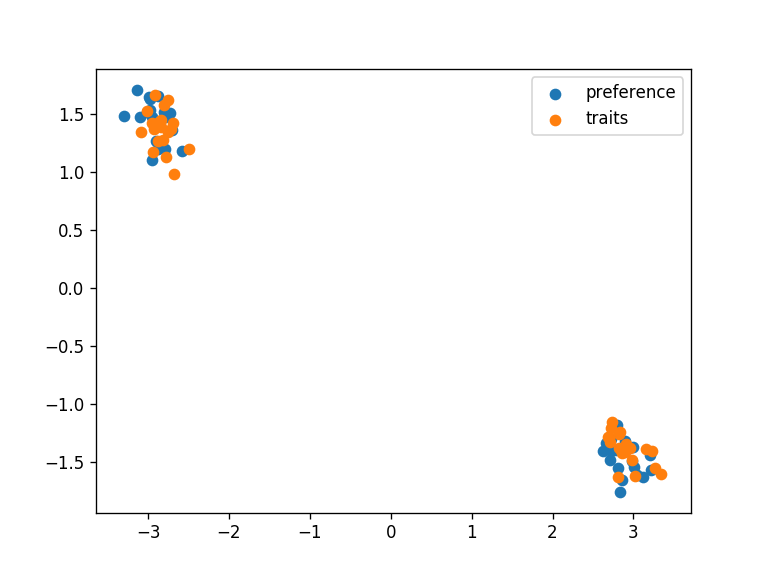

In [17]:
plt.figure()
plt.scatter(preferences_fake[:,0], preferences_fake[:,1],label='preference')
plt.scatter(traits_fake[:,0], traits_fake[:,1], label='traits')
plt.legend()

The preference and traits are nicely separated.

# Baseline
As a baseline implimentation we use the 

In [18]:
print("Running Damped Baseline with beta=0...", end="")
model = DampedUserMovieBaselineModel(damping_factor=0)
model.fit(train_set[['userId', 'movieId']], train_set['rating'])
baseline_prediction = model.predict(val_set[['userId', 'movieId']])


Running Damped Baseline with beta=0...

Evaluate the baseline using accuracy, and NDCG@10.


In [19]:
print(f"NDCG@10 = {get_NDCG(baseline_prediction, val_set, k=10)}")
print(f"MAE = {(baseline_prediction-val_set.rating).abs().mean()}")
#Convert stars to like/dislike
baseline_prediction = [int(stars>=ratings_dict[3.5]) for stars in baseline_prediction]
print(f"Accuracy = {get_precision(baseline_prediction,val_set)}")

NDCG@10 = 0.8781369021807884
MAE = 1.3689790516506686
Accuracy = 0.7060091905266879


We can also calculate the accuracy by just prediction the majority class

# Results
With sanity checks and a baseline in place, we can run our initial model on our data

In [20]:
data, num_users, num_movies = generate_data_dict(train_set, val_set,n_traits=2)

In [21]:
%%time
#sampling takes forever here, but VB seems to work really well
#fit = sm.sampling(data=data, iter=100, algorithm="NUTS", chains=1, seed=seed, verbose=True)
fit = sm.vb(data=data,seed=seed)

CPU times: user 1min 37s, sys: 4.29 s, total: 1min 41s
Wall time: 1min 41s


In [22]:
predictions, probabilities = pystan_utils.vb_extract_predictions(fit)

print(f"NDCG@10 = {get_NDCG(probabilities, val_set, k=10)}")
print(f"Accuracy = {get_precision(predictions,val_set)}")

NDCG@10 = 0.8748873785032355
Accuracy = 0.6709791445740545


The initial model is better than random, but the baseline is a tiny bit better

## Show preferences
Since we are using two number of traits, we can visualize how our model works

In [23]:
preferences=pystan_utils.vb_extract_variable(fit, 'preference[', var_type='matrix', dims=[num_users,2])
traits=pystan_utils.vb_extract_variable(fit, 'trait[', var_type='matrix', dims=[num_movies,2])

<IPython.core.display.Javascript object>


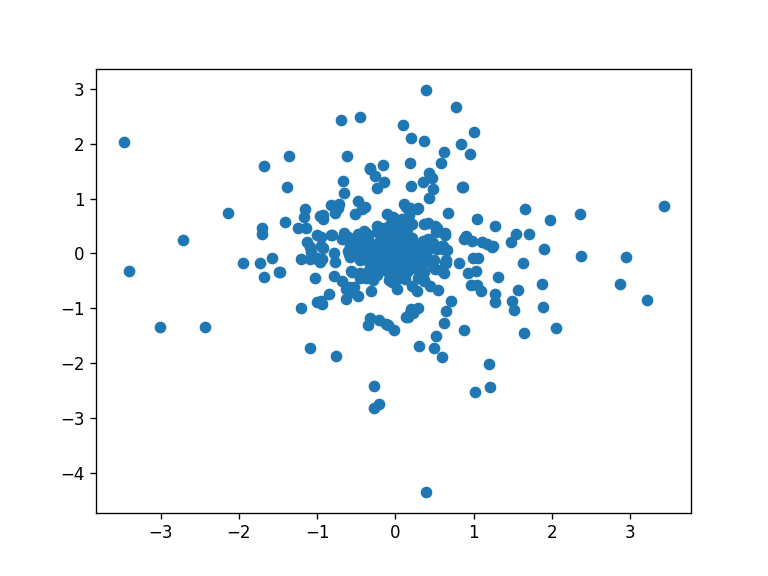

In [24]:
plt.figure()
plt.scatter(preferences[:,0], preferences[:,1])

<IPython.core.display.Javascript object>


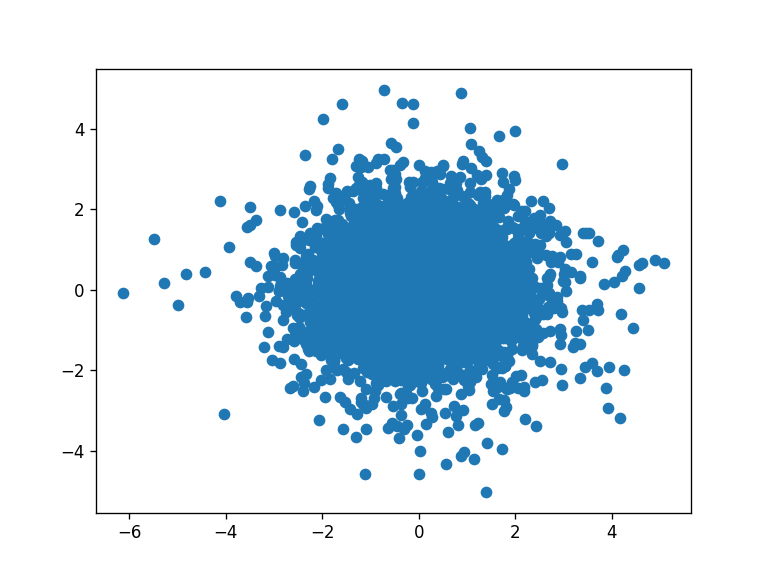

In [53]:
plt.figure()
plt.scatter(traits[:,0], traits[:,1])

Lets plot some extreme values of trait0.

In [25]:
n_extreme = 10
sorted_trait_0_ids = np.argsort(traits[:,0])
lowest_ids = sorted_trait_0_ids[:n_extreme]+1
highest_ids = sorted_trait_0_ids[-n_extreme:]+1
lowest_movie_ids = [ id_movie_dict[lowest_id] for lowest_id in lowest_ids]
highest_movie_ids = [ id_movie_dict[highest_id] for highest_id in highest_ids]

In [26]:
movies[movies.movieId.isin(lowest_movie_ids)]

,movieId,title,genres
331,335,Underneath (1995),Mystery|Thriller
694,706,Sunset Park (1996),Drama
2449,2534,Avalanche (1978),Action
2533,2618,"Castle, The (1997)",Comedy
4403,4498,"Dead Pool, The (1988)",Action|Crime|Thriller
4693,4789,Phantom of the Paradise (1974),Comedy|Fantasy|Horror|Musical|Thriller
4767,4863,Female Trouble (1975),Comedy|Crime
10520,39427,Stay (2005),Thriller
11414,48883,Death of a President (2006),Crime|Drama|Mystery|Thriller
12968,61465,Bangkok Dangerous (2008),Action|Crime|Thriller


In [27]:
movies[movies.movieId.isin(highest_movie_ids)]

,movieId,title,genres
734,747,"Stupids, The (1996)",Comedy
1107,1130,"Howling, The (1980)",Horror|Mystery
1144,1167,Dear God (1996),Comedy
1840,1924,Plan 9 from Outer Space (1959),Horror|Sci-Fi
3199,3286,Snow Day (2000),Comedy
7719,8253,Lupin III: The Castle Of Cagliostro (Rupan san...,Action|Adventure|Animation|Comedy|Crime|Mystery
7763,8362,Raising Helen (2004),Comedy|Drama|Romance
8228,8911,Raise Your Voice (2004),Romance
11606,50802,Because I Said So (2007),Comedy|Drama|Romance
12461,58107,Step Up 2 the Streets (2008),Drama|Musical|Romance


By visual inspection we see that the trait0 doesn't encode an obvious trait of the movie. One could argue, that is might give romantic movies higher values, and thrillers dominate among the lowest values

We expect similar films to have similiar trait values. Let's try and check the Star Wars movies.

<IPython.core.display.Javascript object>


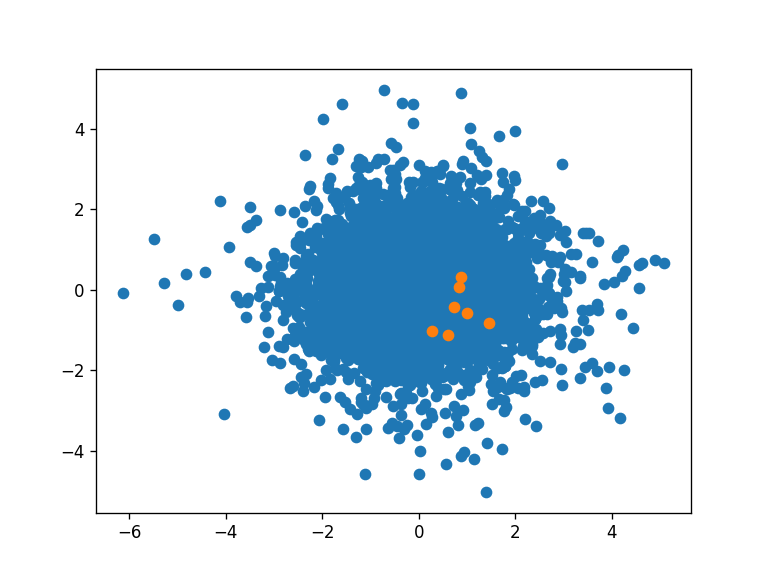

In [28]:
ids_lotr = [movie_id_dict[movie]-1 for movie in  movies[movies.title.str.contains('Star Wars')].movieId if movie in movie_id_dict]
plt.figure()
plt.scatter(traits[:,0], traits[:,1])
plt.scatter(traits[ids_lotr][:,0],traits[ids_lotr][:,1])

We clearly see that the Star Wars movies are grouped pretty close together, suggesting that people that like one of the movies, might also like the others

Plot the movies for which the porsterior of the traits has low variance

<IPython.core.display.Javascript object>


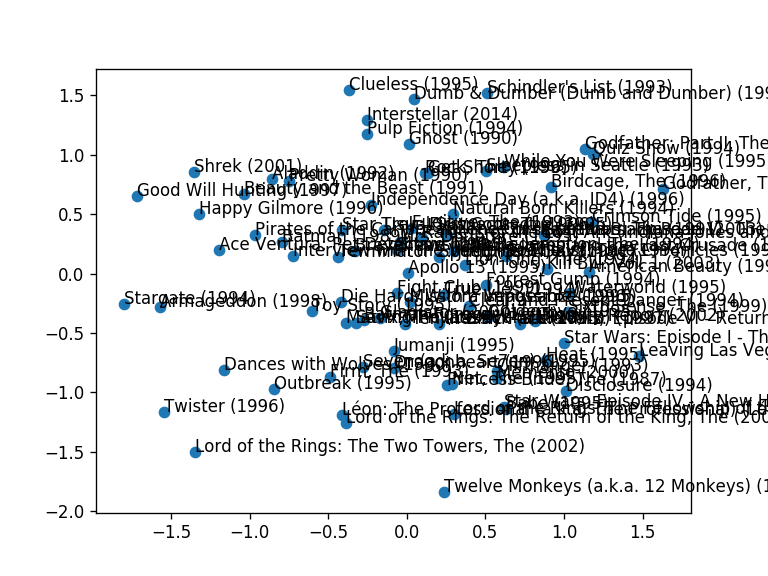

number of movies with low variance posteriors = 86


In [29]:
plot_low_variance_movies(fit,movies,num_movies,id_movie_dict)

Here we again see that the traits seem to group similar movies together, like the lord of the rings trilogy, and two of the god father movies.

# Modelling stars


### PGM

In [30]:
%%HTML
<img src="figs/stars.png" alt="Drawing" style="width: 400px;"/>

### STAN

In [31]:
model_definition = """ data {
    int num_movies;             // number of data items
    int num_traits;
    int num_users;  
    
    int num_likes;

    
    int stars_obs[num_likes];
    int userId_obs[num_likes];
    int movieId_obs[num_likes];
    
    int num_missing;
    int userId_missing [num_missing];
    int movieId_missing [num_missing];
    
}
parameters {
    matrix[num_movies,num_traits] trait;
    matrix[num_users ,num_traits] preference;
    vector[num_movies] trait_bias;
    vector[num_users] preference_bias;
    ordered[9] c;
    
} 

model {
    real affinity;

    for (n in 1:num_likes){
        affinity = 0;
        trait_bias[movieId_obs[n]] ~ normal(0,10);
        preference_bias[userId_obs[n]] ~ normal(0,10);
        for (t in 1:num_traits){
            preference[userId_obs[n], t] ~ normal(0,10);
 
            affinity += trait[movieId_obs[n], t]*preference[userId_obs[n], t];
            
        }
        affinity += trait_bias[movieId_obs[n]] + preference_bias[userId_obs[n]];
        
        stars_obs[n] ~ ordered_logistic(affinity,c);

    }
}

generated quantities {
    int predictions[num_missing];
    
    for(i in 1:num_missing){
        real affinity = 0;
        for (t in 1:num_traits){
            affinity += trait[movieId_missing[i], t] * preference[userId_missing[i], t];
        }
        affinity += trait_bias[movieId_missing[i]] + preference_bias[userId_missing[i]];
        predictions[i] = ordered_logistic_rng(affinity,c);
    }
}
"""

In [32]:
%%time
# create Stan model object
sm_stars = pystan.StanModel(model_code = model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f77195f23262559d1fba08bf46c26f9f NOW.


CPU times: user 3.34 s, sys: 2.53 s, total: 5.87 s
Wall time: 1min 32s


In [33]:
data, num_users, num_movies = generate_data_dict(train_set, val_set,n_traits=2, stars=True)

In [34]:
%%time
#sampling takes forever here, but VB seems to work really well
#fit = sm.sampling(data=data, iter=100, algorithm="NUTS", chains=1, seed=seed, verbose=True)
fit_stars = sm_stars.vb(data=data,seed=seed)

CPU times: user 2min 5s, sys: 4.41 s, total: 2min 10s
Wall time: 2min 9s


In [35]:
predictions_stars, probabilities_stars = pystan_utils.vb_extract_predictions(fit_stars)

In [36]:
print(f"NDCG@10 = {get_NDCG(probabilities_stars, val_set, k=10)}")
print(f"MAE = {(predictions_stars-val_set.rating).abs().mean()}")

#Convert stars to like/dislike
predictions_stars = [int(stars>=ratings_dict[3.5]) for stars in predictions_stars]
print(f"Accuracy = {get_precision(predictions_stars,val_set)}")

NDCG@10 = 0.886062735496995
MAE = 1.7407211028632026
Accuracy = 0.6542948038176034


By including stars in the model, the accuracy went a bit down, but the NDCG which we care more about, is now outperforming the baseline.
Next we can try and plot the cuts we have learned for our ordered regression:

<IPython.core.display.Javascript object>


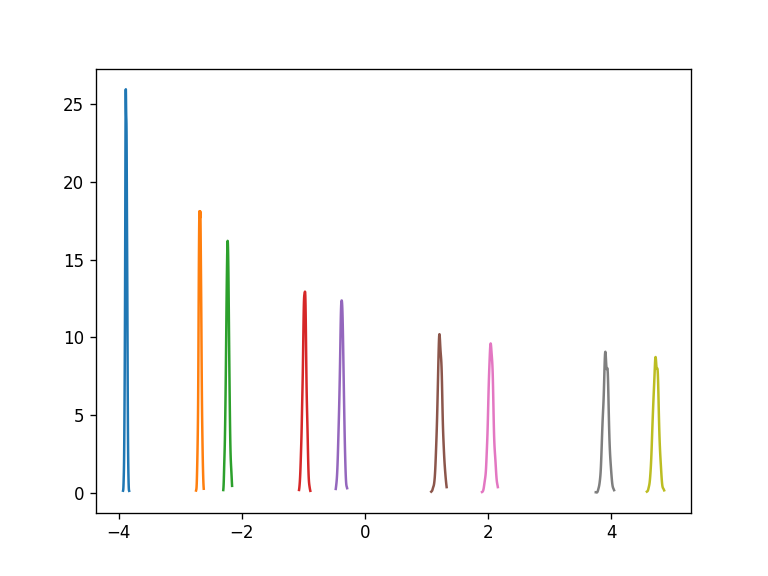

In [37]:
samples,_,_,_=pystan_utils.vb_extract(fit_stars)
plt.figure()
for i in range(1,10):
    pystan_utils.plot_kde( samples[f'c[{i}]'])

In [44]:
samples,means,stds,varnames=pystan_utils.vb_extract(fit_stars)

# Adding additional features (final model)

### PGM

In [38]:
%%HTML
<img src="figs/stars_features.png" alt="Drawing" style="width: 400px;"/>

### STAN

In [73]:
model_definition_genre = """ data {
    int num_movies;             // number of data items
    int num_traits;
    int num_users;  
    
    int num_likes;

    
    int stars_obs[num_likes];
    int userId_obs[num_likes];
    int movieId_obs[num_likes];
    
    int num_missing;
    int userId_missing [num_missing];
    int movieId_missing [num_missing];
    
    matrix[num_likes,20] genre;
    
}
parameters {
    matrix[num_movies,num_traits] trait;
    matrix[num_users ,num_traits] preference;
    vector[num_movies] trait_bias;
    vector[num_users] preference_bias;
    matrix[20,num_traits] genre_weight;
    vector[num_traits] genre_bias;
    ordered[9] cut;
    
} 

model {
    real affinity;
    row_vector[num_traits] traitMean;
    
    //for (c in 1:9){
    //    cut[c] ~ uniform(-10,10);
    //}
    
    
    for (t in 1:num_traits){
        genre_bias[t] ~ normal(0,10);
        for (g in 1:20){
            genre_weight[g][t] ~ normal(0,10);
        }
    }
    
    
    

    for (n in 1:num_likes){
        affinity = 0;
        
        traitMean = genre[n]*genre_weight + genre_bias';
        
        trait_bias[movieId_obs[n]] ~ normal(0,10);
        preference_bias[userId_obs[n]] ~ normal(0,10);
        
        
        for (t in 1:num_traits){
            
            preference[userId_obs[n], t] ~ normal(0,10);
            trait[movieId_obs[n], t] ~ normal(traitMean[t] ,10);

            affinity += trait[movieId_obs[n], t]*preference[userId_obs[n], t];
            
        }
        affinity += trait_bias[movieId_obs[n]] + preference_bias[userId_obs[n]];
        
        stars_obs[n] ~ ordered_logistic(affinity,cut);

    }
}

generated quantities {
    int predictions[num_missing];
    
    for(i in 1:num_missing){
        real affinity = 0;
        for (t in 1:num_traits){
            affinity += trait[movieId_missing[i], t] * preference[userId_missing[i], t];
        }
        affinity += trait_bias[movieId_missing[i]] + preference_bias[userId_missing[i]];
        predictions[i] = ordered_logistic_rng(affinity,cut);
    }
}
"""

In [74]:
%%time
# create Stan model object
sm_genre = pystan.StanModel(model_code = model_definition_genre)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_68146abb598cf42e7ed22fd50f35e54d NOW.


CPU times: user 1.68 s, sys: 436 ms, total: 2.12 s
Wall time: 1min 18s


In [75]:
data, num_users, num_movies = generate_data_dict(train_set, val_set,n_traits=2, genre=True, stars=True) 

In [76]:
%%time
#sampling takes forever here, but VB seems to work really well
#fit = sm.sampling(data=data, iter=100, algorithm="NUTS", chains=1, seed=seed, verbose=True)
fit_genre = sm_genre.vb(data=data,seed=seed)

CPU times: user 3min 29s, sys: 4.64 s, total: 3min 34s
Wall time: 3min 33s


In [77]:
predictions_genre, probabilities_genre = pystan_utils.vb_extract_predictions(fit_genre)
print(f"NDCG@10 = {get_NDCG(probabilities_genre, val_set, k=10)}")
print(f"MAE = {(predictions_genre-val_set.rating).abs().mean()}")

#Convert stars to like/dislike
predictions_genre = [int(stars>=ratings_dict[3.5]) for stars in predictions_genre]
print(f"Accuracy = {get_precision(predictions_genre,val_set)}")

NDCG@10 = 0.887058526313382
MAE = 1.727960410038883
Accuracy = 0.6586426299045599


We can try to increase the performance of our model by increasing the number of traits

In [100]:
data, num_users, num_movies = generate_data_dict(train_set, val_set,n_traits=16, genre=True, stars=True) 

In [101]:
%%time
#sampling takes forever here, but VB seems to work really well
#fit = sm.sampling(data=data, iter=100, algorithm="NUTS", chains=1, seed=seed, verbose=True)
fit_genre_large = sm_genre.vb(data=data,seed=seed)

CPU times: user 11min 34s, sys: 19.2 s, total: 11min 53s
Wall time: 11min 50s


In [128]:
predictions_genre, probabilities_genre = pystan_utils.vb_extract_predictions(fit_genre_large)
print(f"NDCG@10 = {get_NDCG(probabilities_genre, val_set, k=10)}")
print(f"MAE = {(predictions_genre-val_set.rating).abs().mean()}")
#Convert stars to like/dislike
predictions_genre = [int(stars>=ratings_dict[3.5]) for stars in predictions_genre]
print(f"Accuracy = {get_precision(predictions_genre,val_set)}")

NDCG@10 = 0.892190406220328
MAE = 1.7376458112407211
Accuracy = 0.6646518204312477


# Discussion

The performance of our model is a bit underwelming. We can try to look at the porsterior distribution of the predictions, to see if the model has well estimated predictions

<IPython.core.display.Javascript object>


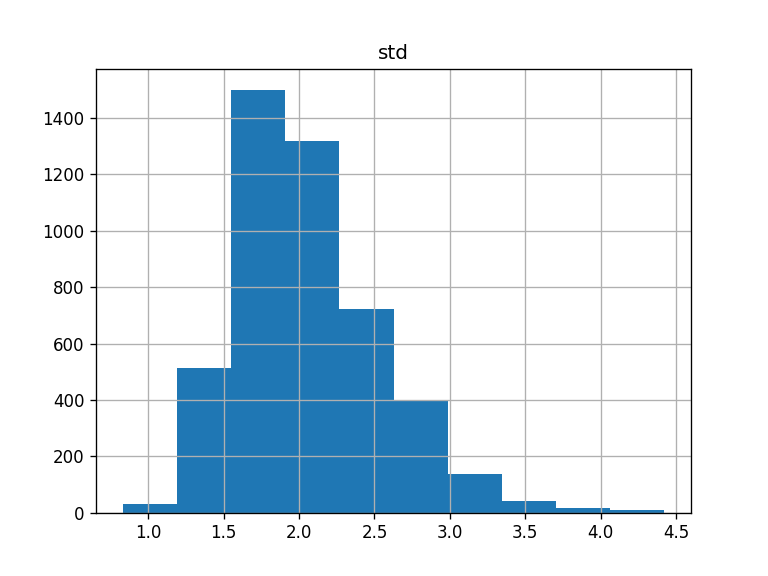

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe1b2bef278>]],
      dtype=object)

In [129]:
samples,means,stds,var_names=pystan_utils.vb_extract(fit_genre)
std = []
mean = []
for i in range(1,len(val_set)+1):
    std.append(stds[f"predictions[{i}]"])
    mean.append(means[f"predictions[{i}]"])
    
val_set['std'] = std
val_set['prediction'] = mean
val_set['diff'] = abs(val_set['rating'] - val_set['prediction'])
val_set.groupby('movieIdNoHoles').mean().hist('std')

In general, the standard deviation of the porsterior for the prediction is quite large, meaning that our model isn't very certain in it's predictions.
We know from the data exploration, that a large amount of movies have extremely few ratings. 
Let's try and see if the uncertaincy depends on number of ratings for each movie

<IPython.core.display.Javascript object>


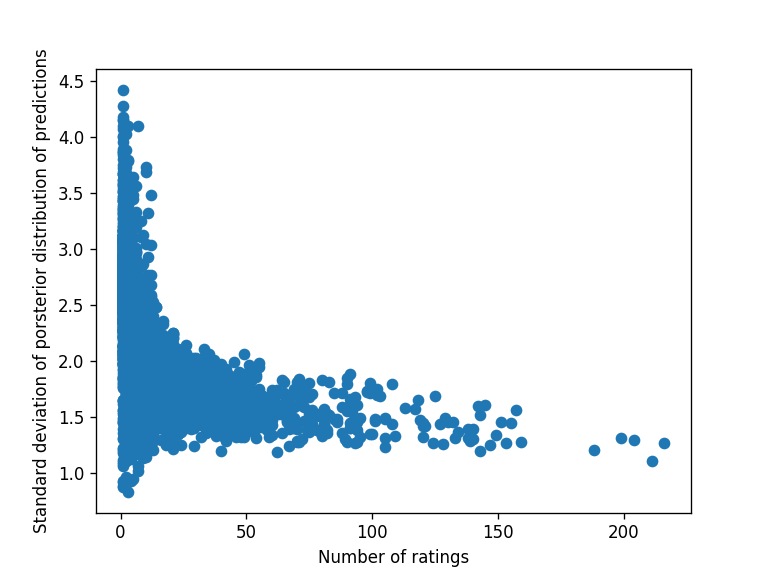

Text(0, 0.5, 'Standard deviation of porsterior distribution of predictions')

In [130]:
df =val_set.groupby('movieIdNoHoles').mean()
df['count'] = train_set.groupby('movieIdNoHoles').count()['rating']

plt.figure()
plt.scatter(df['count'], df['std'])
plt.xlabel('Number of ratings')
plt.ylabel('Standard deviation of porsterior distribution of predictions')

Since we are taking the mean of the standard deviations for each movie, the movies with few ratings, not surprisingly, have more spread, but in general it seems like there is only a very slight decrease in standard deviation, as you increase the number of ratings per movie

<IPython.core.display.Javascript object>


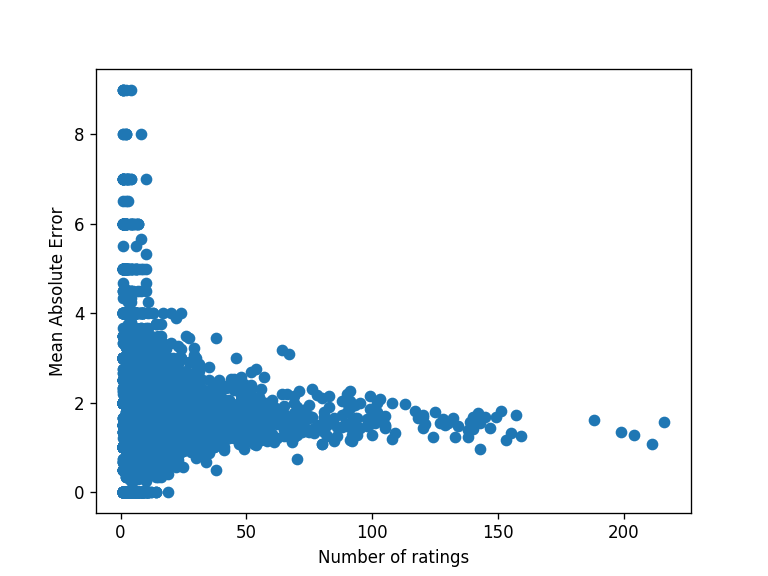

Text(0, 0.5, 'Mean Absolute Error')

In [131]:
plt.figure()
plt.scatter(df['count'], df['diff'])
plt.xlabel('Number of ratings')
plt.ylabel('Mean Absolute Error')

When looking at the MAE of the predictions instead of the std, we see a similar story, where having more ratings per movie, does not necessarely decrease the prediction error.